# DESCRIPTION
#### L'entreprise X fait du E-commerce et vend des vêtements faits-main. Votre but est de construire un modèle qui permette de prédire si l'achat d'un vêtement doit être considéré comme une transaction frauduleuse ou non.

Voici précisément ce que vous devez faire :

Pour chacun des utilisateurs, déterminez le pays d'origine depuis son adresse IP

Construisez un modèle qui permette de prédire si l'activité est frauduleuse ou non. Expliquez aussi vos choix / hypothèses en termes d'optimisation de faux-positifs et faux-négatifs

Votre patron aimerait comprendre votre modèle car il est inquiet d'utiliser un modèle black box. Comment l'expliqueriez vous d'un point utilisateur, et non pas mathématique. Par exemple, quels sont les utilisateurs qui peuvent être classés comme risqués ?

Supposons que vous pouvez utiliser votre modèle en live pour qu'il fasse sa prédiction en temps réel. D'un point de vue Produit, comment l'utiliseriez-vous ? Comment pourriez-vous penser l'expérience utilisateur face à ce produit ?

In [172]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings      
warnings.filterwarnings("ignore")

#  EDA :

# Analyse des données

In [173]:
dataset = pd.read_csv("Fraud_Data.csv",sep=",")

In [174]:
dataset_2 = pd.read_csv("IpAddress_to_Country.csv",sep=",")

In [175]:
dataset.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [176]:
dataset_2.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [177]:
dataset.shape

(151112, 11)

In [178]:
dataset_2.shape

(138846, 3)

In [179]:
country = len(dataset) * [0]

for ind, row in dataset.iterrows():
    temp = dataset_2[(dataset_2['lower_bound_ip_address'] < row['ip_address']) & 
           (dataset_2['upper_bound_ip_address'] > row['ip_address'])]['country']
    
    if len(temp) == 1:
        country[ind] = temp.values[0]

dataset['country'] = country


In [180]:
dataset.to_csv("datastprep.csv", sep=",")

In [181]:
dataset.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [182]:
dataset["class"].value_counts()

0    136961
1     14151
Name: class, dtype: int64

In [183]:
dataset["class"].value_counts(normalize=True)

0    0.906354
1    0.093646
Name: class, dtype: float64

Le variable class est notre variable target  il peut prendre 0 ou 1

1 signifie que il y a fraude , 0 signifie le contraire.

les 2 class sont imbalanced 91% de  0 et 9% de 1


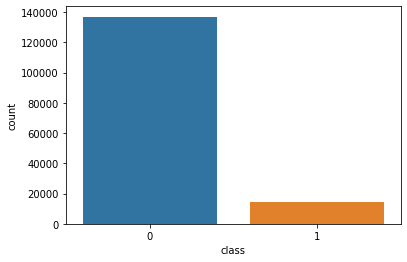

In [184]:
sns.countplot(dataset["class"]) #imbalanced dataset

##  1- Analyse des variables categorielle

In [185]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
 11  country         151112 non-null  object 
dtypes: float64(1), int64(4), object(7)
memory usage: 13.8+ MB


In [186]:
dataset['signup_time'] = pd.to_datetime(dataset['signup_time'])
dataset['purchase_time'] = pd.to_datetime(dataset['purchase_time'])

SEO       0.401126
Ads       0.396269
Direct    0.202605
Name: source, dtype: float64


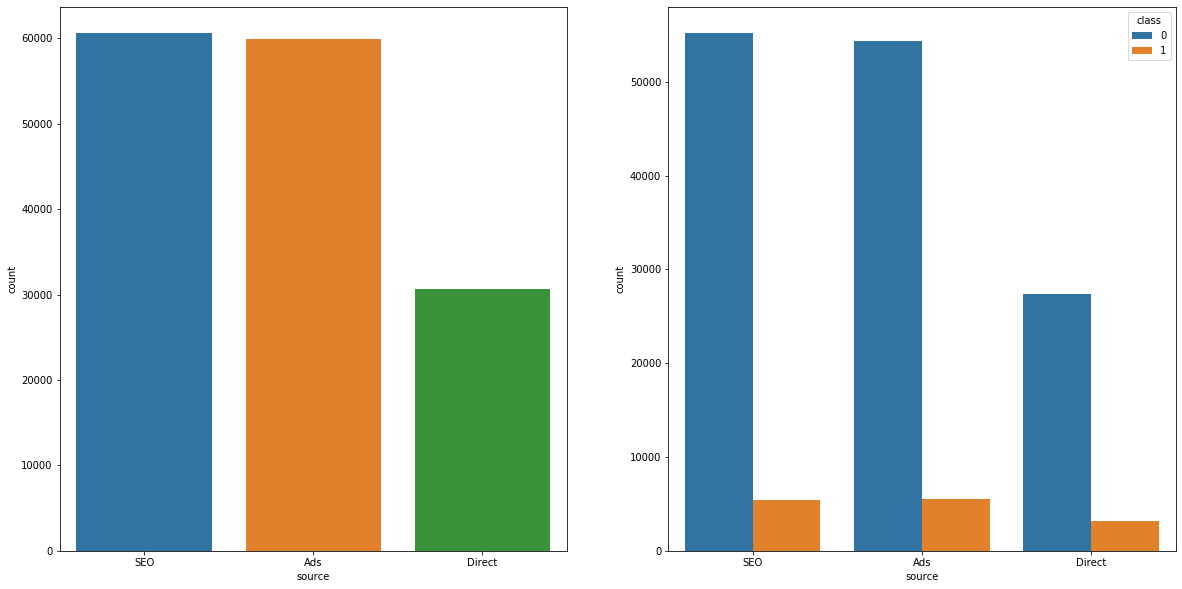

In [187]:
print(dataset.source.value_counts(normalize=True))  
plt.figure(figsize=(20,10))
plt.subplot(121) 
sns.countplot(dataset.source)
plt.subplot(122) 
sns.countplot(dataset.source,hue=dataset["class"])
plt.show()

In [188]:
#Calculate fraud rate by source
fraud_rate = dataset[dataset['class']==1].source.value_counts()/dataset.source.value_counts(sort=False)
fraud_rate #  same rate

Ads       0.092066
Direct    0.105370
SEO       0.089285
Name: source, dtype: float64

Chrome     0.406533
IE         0.243045
Safari     0.163237
FireFox    0.162859
Opera      0.024326
Name: browser, dtype: float64


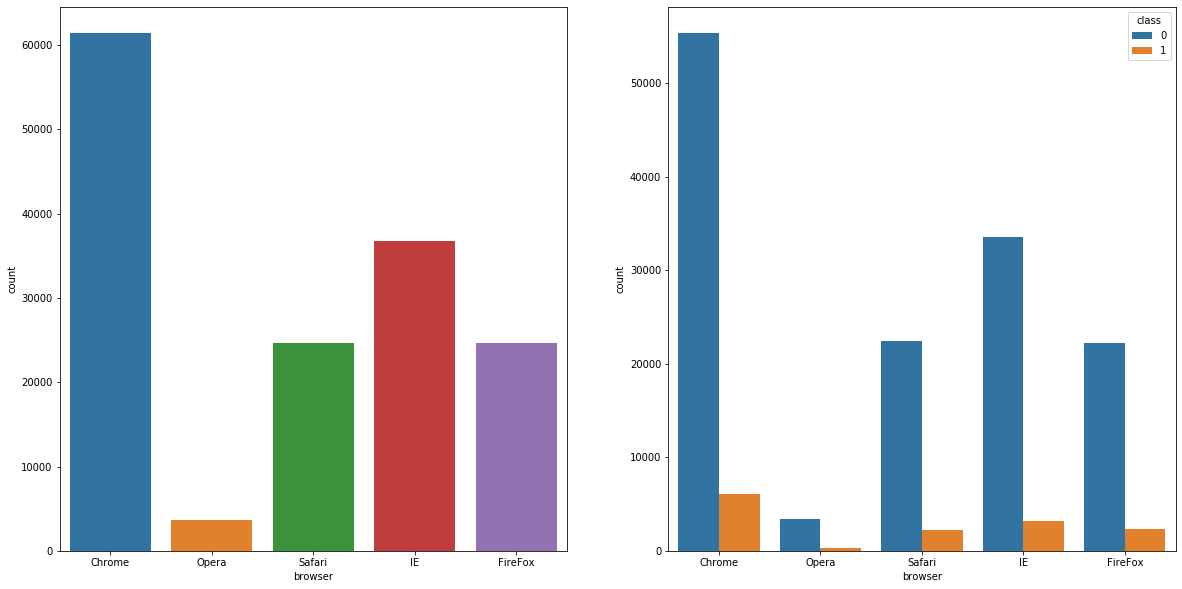

In [189]:
print(dataset.browser.value_counts(normalize=True))  
plt.figure(figsize=(20,10))
plt.subplot(121) 
sns.countplot(dataset.browser)
plt.subplot(122) 
sns.countplot(dataset.browser,hue=dataset["class"])
plt.show()

In [190]:
#Calculate fraud rate by browser
fraud_rate = dataset[dataset['class']==1].browser.value_counts()/dataset.browser.value_counts(sort=False)
fraud_rate #  same rate

Chrome     0.098792
FireFox    0.095165
IE         0.086775
Opera      0.089227
Safari     0.090201
Name: browser, dtype: float64

M    0.584288
F    0.415712
Name: sex, dtype: float64


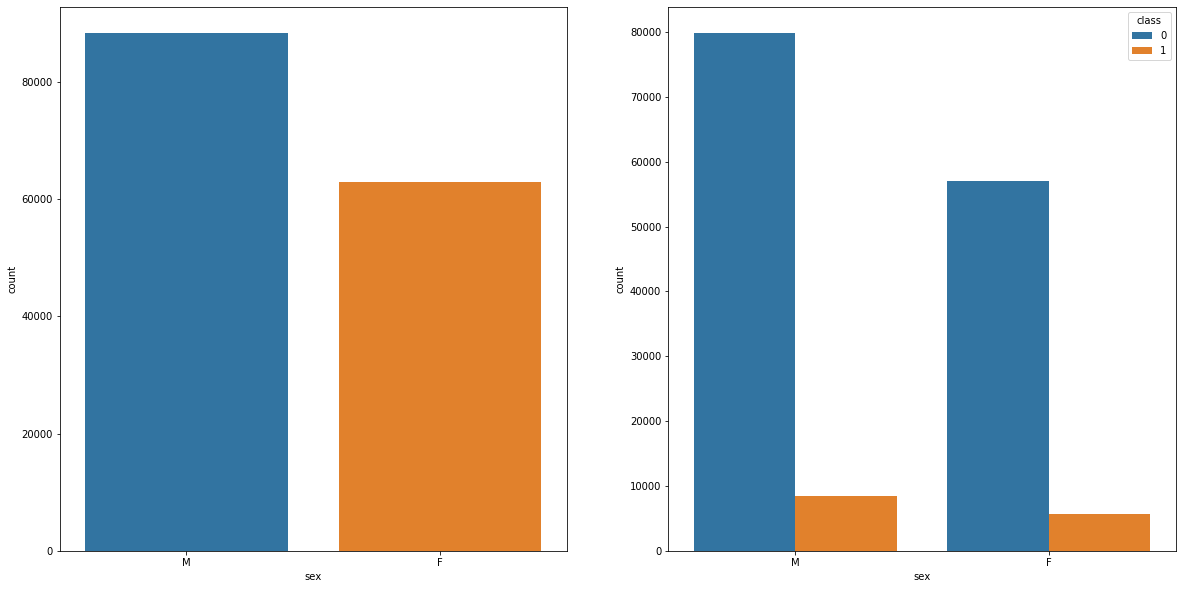

In [191]:
print(dataset.sex.value_counts(normalize=True))  
plt.figure(figsize=(20,10))
plt.subplot(121) 
sns.countplot(dataset.sex)
plt.subplot(122) 
sns.countplot(dataset.sex,hue=dataset["class"])
plt.show()

In [192]:
#Calculate fraud rate by sex
fraud_rate = dataset[dataset['class']==1].sex.value_counts()/dataset.sex.value_counts(sort=False)
fraud_rate #  same rate

F    0.091007
M    0.095523
Name: sex, dtype: float64

In [193]:
# print(dataset.country.value_counts(normalize=True).head())  
# plt.figure(figsize=(20,10))
# plt.subplot(121) 
# sns.countplot(dataset.country)
# plt.subplot(122) 
# sns.countplot(dataset.country,hue=dataset["class"])
# plt.show()

In [194]:
#Calculate  frequence fraud rate by country
fraud_rate = dataset[dataset['class']==1].country.value_counts()/dataset.country.value_counts(sort=True)
fraud_rate.sort_values(ascending=False).head(20) #  top rate country with fraud

Turkmenistan             1.000000
Namibia                  0.434783
Sri Lanka                0.419355
Luxembourg               0.388889
Virgin Islands (U.S.)    0.333333
Ecuador                  0.264151
Tunisia                  0.262712
Peru                     0.260504
Bolivia                  0.245283
Kuwait                   0.233333
Ireland                  0.229167
New Zealand              0.223022
Uzbekistan               0.200000
Lithuania                0.189474
Saudi Arabia             0.189394
Malta                    0.181818
Cote D'ivoire            0.166667
Afghanistan              0.166667
Denmark                  0.159184
Chile                    0.153477
Name: country, dtype: float64

In [195]:
device_data = pd.DataFrame(dataset.groupby('device_id')['class'].value_counts())

device_data

class
device_id     class       
AAALBGNHHVMKG 0          1
AAAWIHVCQELTP 0          1
AAAXJHWCLISKY 0          1
AAAXXOZJRZRAO 1         10
              0          1
...                    ...
ZZZGSIJRNCXBJ 0          1
ZZZIKLJSVSQMF 0          1
ZZZKJIZHJEDFN 0          1
ZZZMVOGBAJVTM 0          1
ZZZXASJUVUNMV 0          1

[140641 rows x 1 columns]

In [196]:
dataset.device_id.value_counts()

CQTUVBYIWWWBC    20
NGQCKIADMZORL    20
ZUSVMDEZRBDTX    20
KIPFSCNUGOLDP    20
ITUMJCKWEYNDD    20
                 ..
ROQXQUTBZHTWI     1
DPNFLPIOCBYIF     1
AJFXRCJCZYAAU     1
SVVTHKSMPMCCK     1
QVVVDFEZZYZHC     1
Name: device_id, Length: 137956, dtype: int64

In [197]:
dataset_fraud = dataset[dataset["class"] ==1]
dataset_no_fraud = dataset[dataset["class"] ==0]

In [198]:
dataset_fraud.groupby(['device_id'])['class'].count()

device_id
AAAXXOZJRZRAO    10
AADGMPYOPXXCX     1
AAEWGRKQJJMVI     1
AAIEIZJZIKDLN     1
AAJCSUCPHKORJ     1
                 ..
ZZJGHWLIVVIIS     1
ZZMFOPGWVVSHV     1
ZZQBRNNATFEIW     1
ZZQPVRBHRMVYD    11
ZZUBRTQITHWAO     1
Name: class, Length: 6987, dtype: int64

In [199]:
dataset_no_fraud.groupby(['device_id'])['class'].count()

device_id
AAALBGNHHVMKG    1
AAAWIHVCQELTP    1
AAAXJHWCLISKY    1
AAAXXOZJRZRAO    1
AABFGRPBQHWFQ    1
                ..
ZZZGSIJRNCXBJ    1
ZZZIKLJSVSQMF    1
ZZZKJIZHJEDFN    1
ZZZMVOGBAJVTM    1
ZZZXASJUVUNMV    1
Name: class, Length: 133654, dtype: int64

##  2- Analyse des variables numerique

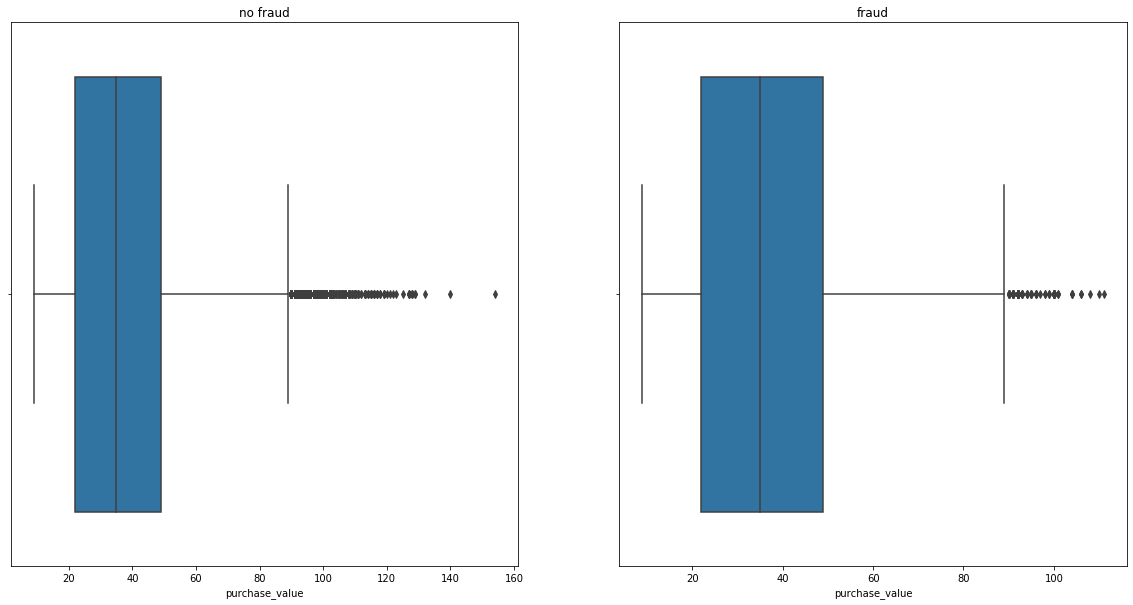

In [200]:
 
plt.figure(figsize=(20,10))
plt.subplot(121) 
sns.boxplot(dataset_no_fraud["purchase_value"]).set_title("no fraud")
plt.subplot(122) 
sns.boxplot(dataset_fraud["purchase_value"]).set_title("fraud")
plt.show()

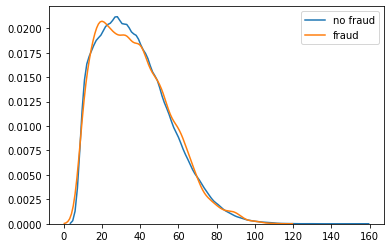

In [201]:
# sns.distplot(dataset["purchase_value"],hue=dataset["class"])
sns.kdeplot(dataset_no_fraud["purchase_value"], label='no fraud')
sns.kdeplot(dataset_fraud["purchase_value"], label='fraud')

In [202]:
sum_connexion_fraud = dataset_fraud[['user_id', 'device_id']].groupby('device_id').count()
sum_connexion_fraud = sum_connexion_fraud.rename(columns={'user_id': 'connexion'})
#number of conexion by device
sum_connexion_Nofraud = dataset_no_fraud[['user_id', 'device_id']].groupby('device_id').count()
sum_connexion_Nofraud = sum_connexion_Nofraud.rename(columns={'user_id': 'connexion'})


In [203]:
sss =pd.DataFrame(dataset_no_fraud.groupby(['device_id'])['class'].count())

In [204]:
number_connex_no_fraud = sss.reset_index(drop= True)

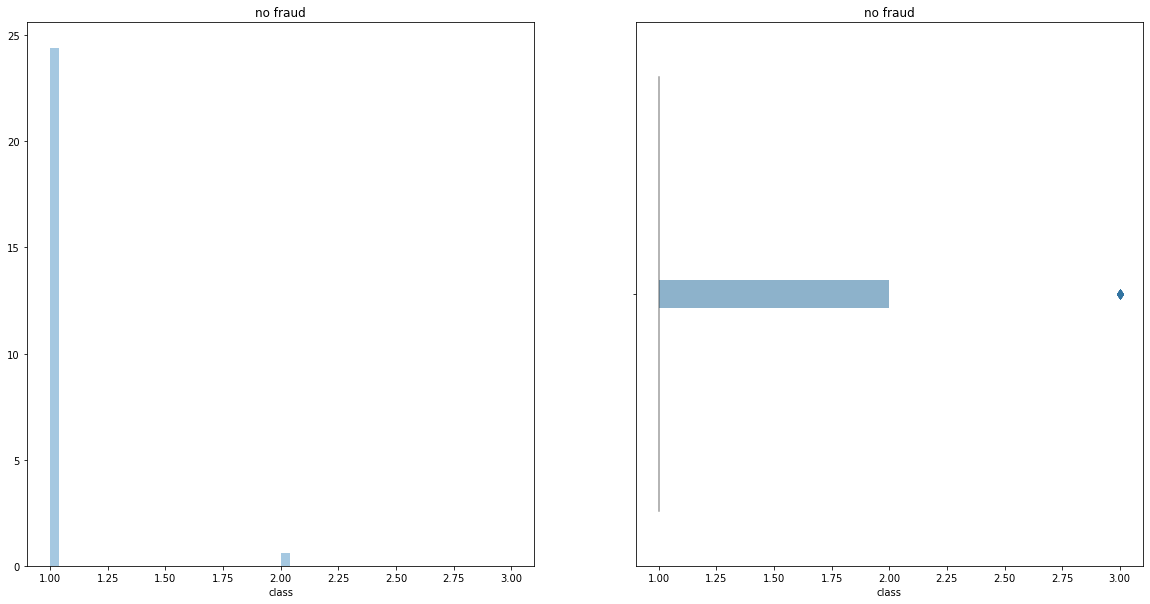

In [205]:

#the number of connexion/device  is betwen 1 - 3

plt.figure(figsize=(20,10))
plt.subplot(121) 
sns.distplot(number_connex_no_fraud["class"]).set_title("no fraud")
plt.subplot(122) 
sns.boxenplot(number_connex_no_fraud["class"]).set_title("no fraud")
plt.show()

In [206]:
sss =pd.DataFrame(dataset_fraud.groupby(['device_id'])['class'].count())

In [207]:
number_connex_fraud = sss.reset_index(drop= True)

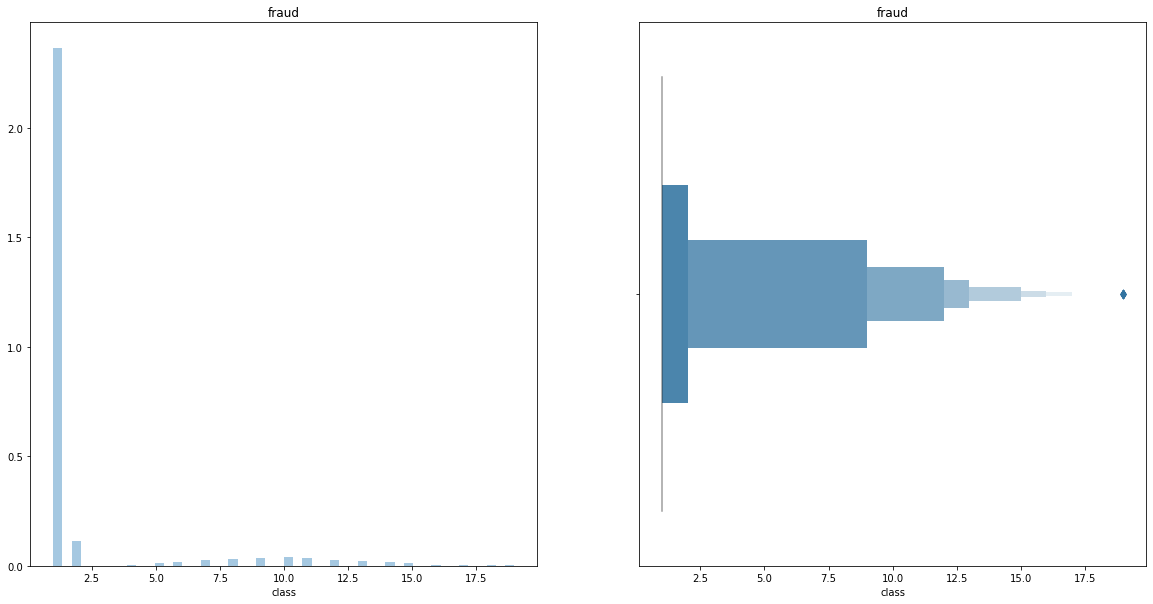

In [208]:
#the number of connexion/device is betwen 1 - 19

plt.figure(figsize=(20,10))
plt.subplot(121) 
sns.distplot(number_connex_fraud["class"]).set_title("fraud")
plt.subplot(122) 
sns.boxenplot(number_connex_fraud["class"]).set_title("fraud")
plt.show()


In [209]:
#Difference between signup_time time and purchase time
dataset['diff_time'] = (dataset['purchase_time'] - dataset['signup_time'])/np.timedelta64(1, 's')

In [210]:
dataset.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,diff_time
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,4506682.0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944.0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1.0
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,0,492085.0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,4361461.0


In [211]:
dataset_fraud = dataset[dataset["class"] ==1]
dataset_no_fraud = dataset[dataset["class"] ==0]

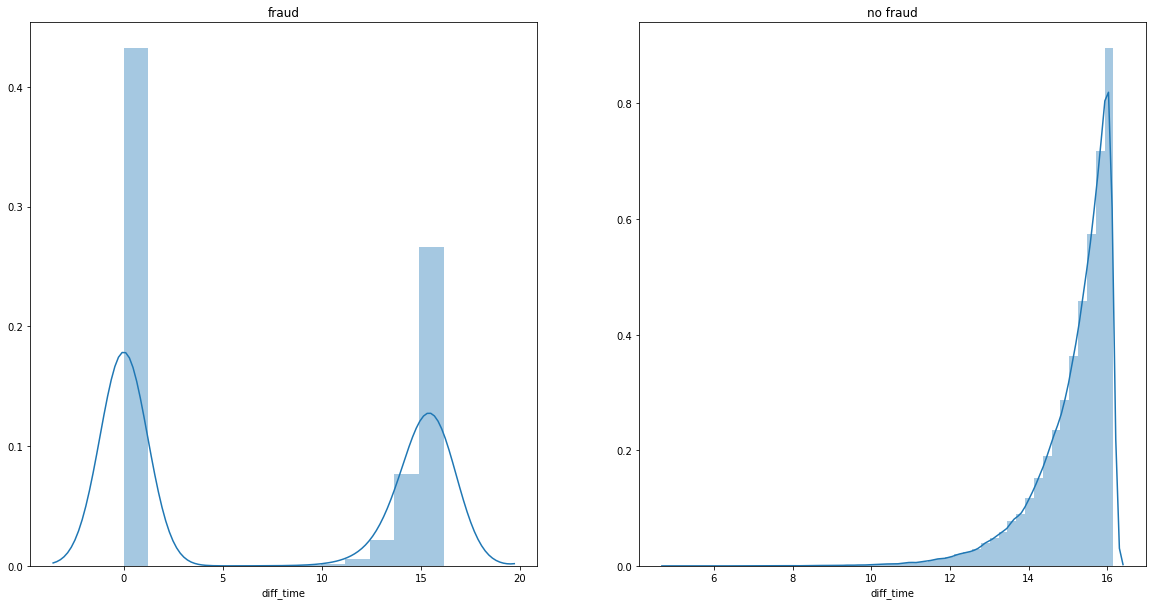

In [212]:


plt.figure(figsize=(20,10))
plt.subplot(121) 
sns.distplot(np.log(dataset_fraud["diff_time"])).set_title("fraud")
plt.subplot(122) 
sns.distplot(np.log(dataset_no_fraud["diff_time"])).set_title("no fraud")
plt.show()

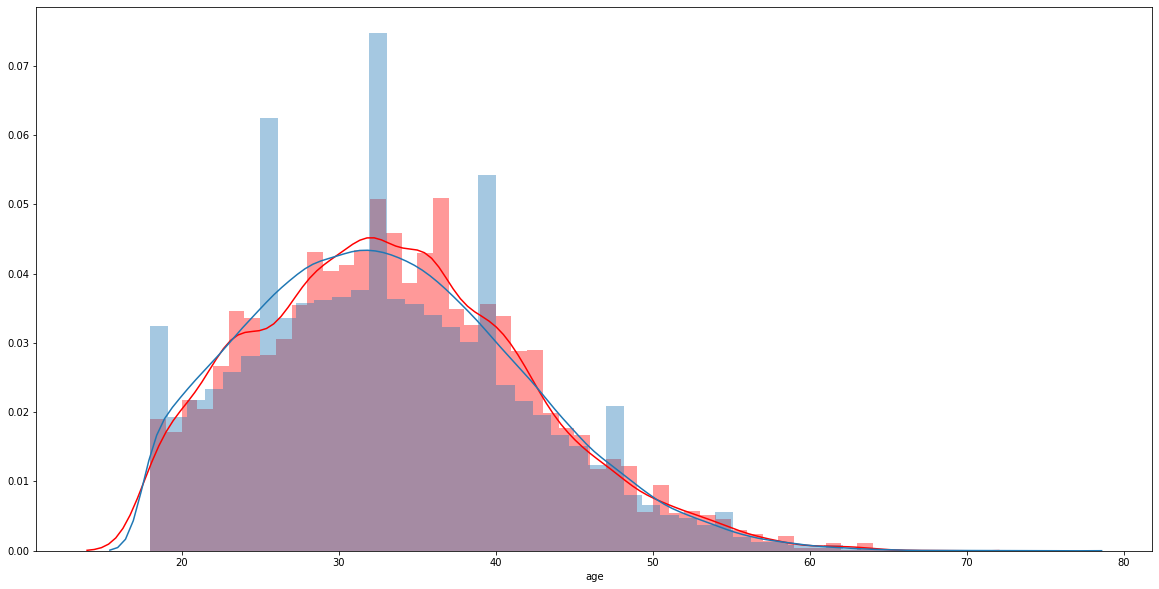

In [213]:
plt.figure(figsize=(20,10))
sns.distplot(dataset_fraud["age"],color="r")
sns.distplot(dataset_no_fraud["age"])
plt.show()

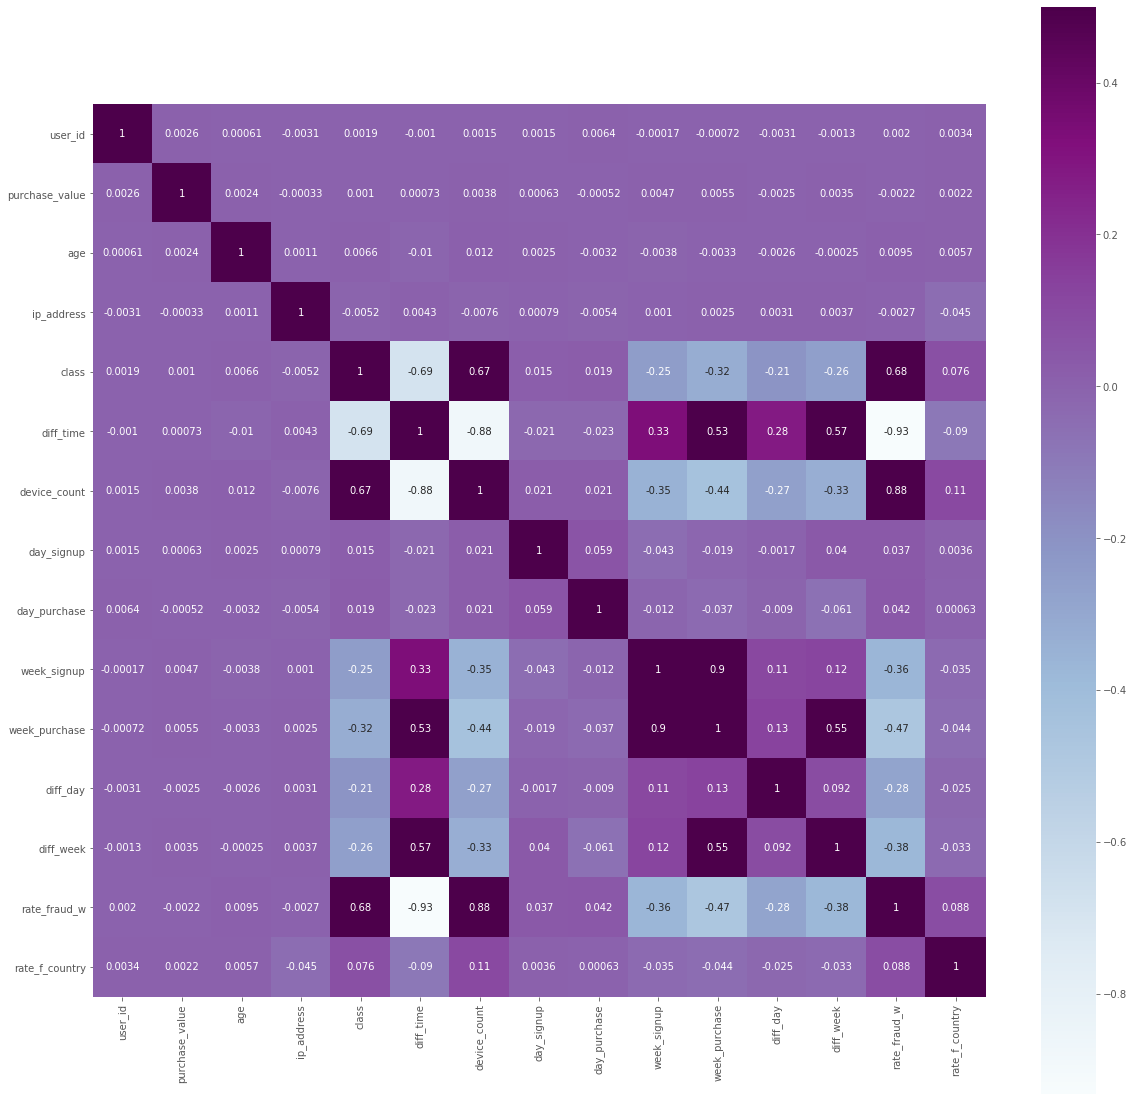

In [506]:
### a refaire !!!!


corela = dataset.corr()
f, ax = plt.subplots(figsize=(20, 20)) 
sns.heatmap(corela, vmax=.5, square=True, cmap="BuPu",annot=True);

# Modélisation :

## L'objectif

#### Construisez un modèle qui permette de prédire si l'activité est frauduleuse ou non.

#### Le variable cible a predire est class : " 0" : no fraud ,  1 : fraud

#### Notre dataset  est déséquilibre  91% de 0 et  9% de 1

## Métrique d'évaluation:

#### Le Recall est notre métrique d'évaluation  on cherche a predire au maximum les fraudes  donc " class =1"


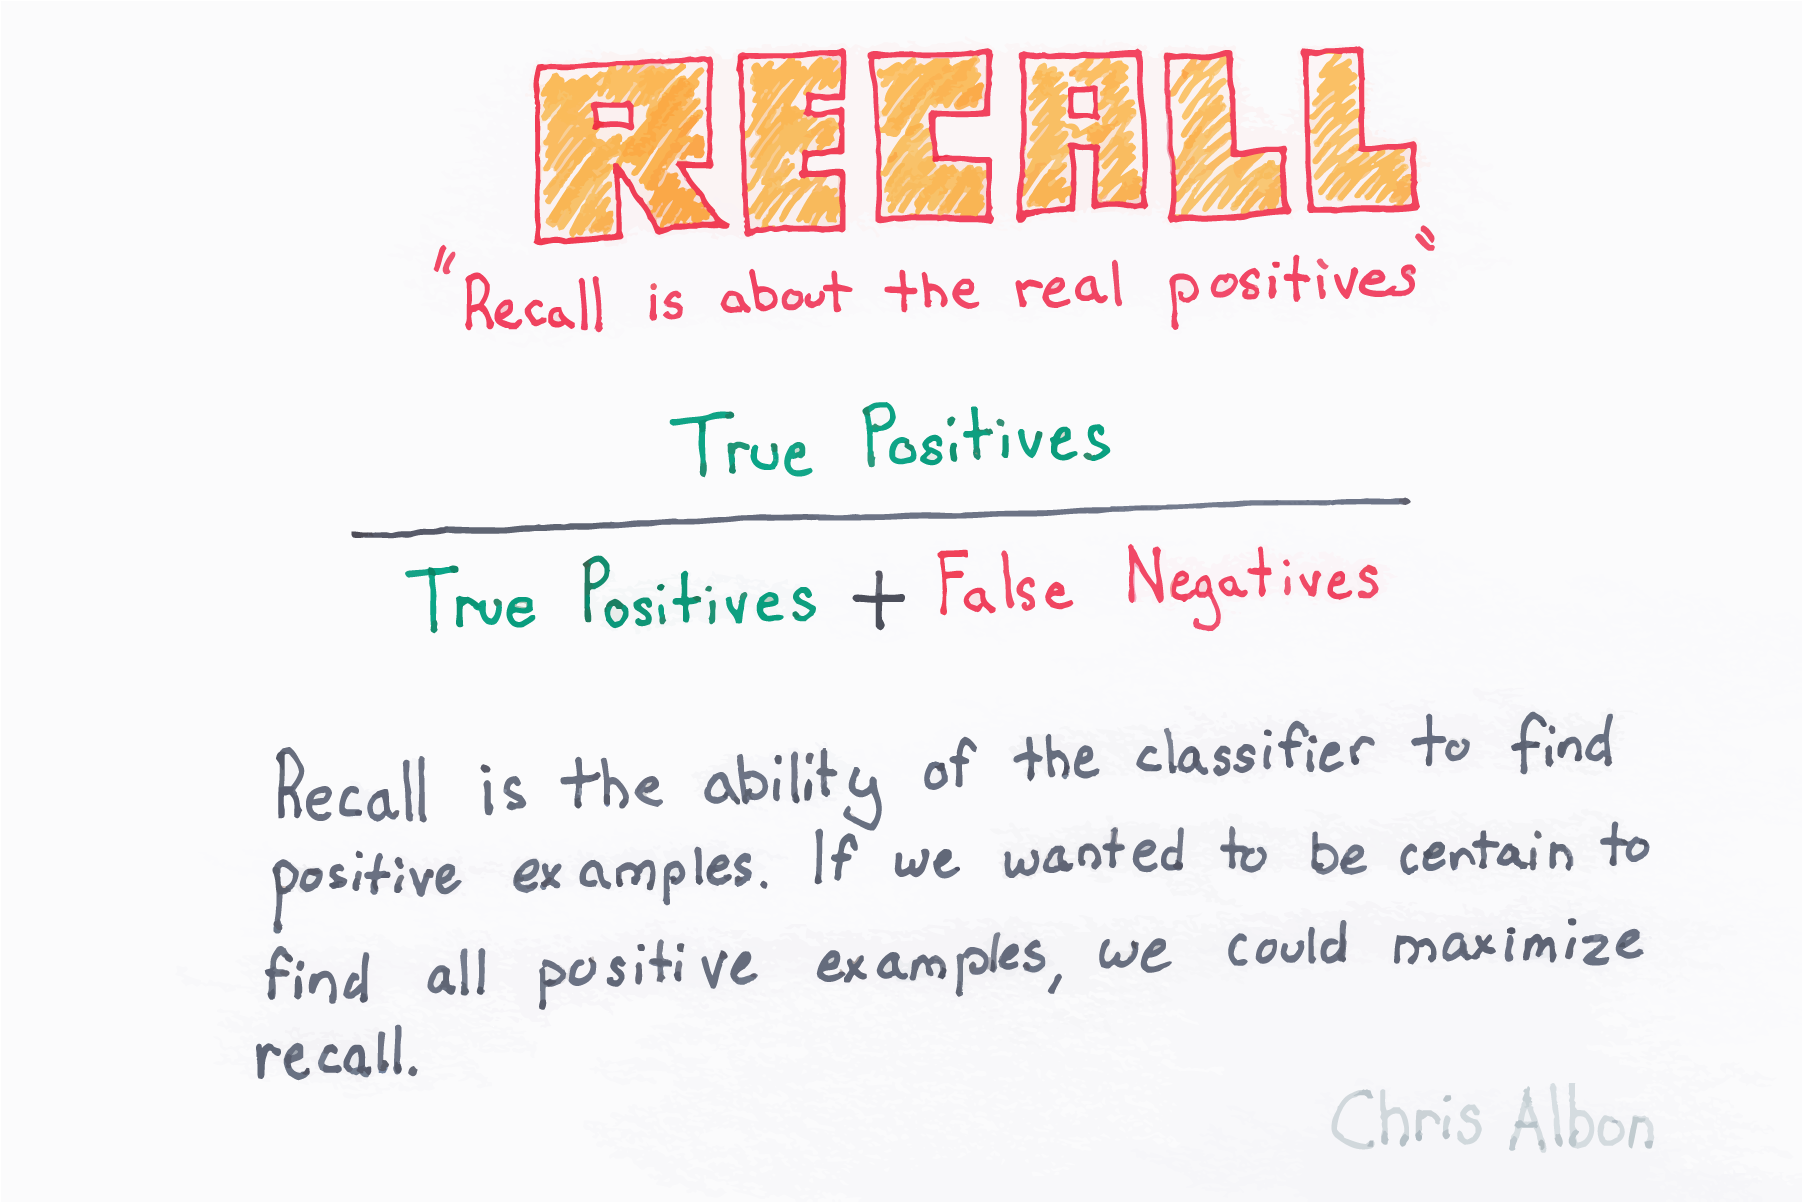

### Preprocessing

In [215]:
dataset.columns

Index(['user_id', 'signup_time', 'purchase_time', 'purchase_value',
       'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class',
       'country', 'diff_time'],
      dtype='object')

In [216]:
X=dataset.drop(["class",'user_id','signup_time','purchase_time','ip_address'],axis=1)
y=dataset["class"]

In [217]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
X['country'] = le.fit_transform(X['country'].astype(str))
X['device_id'] = le.fit_transform(X['device_id'].astype(str))

In [218]:
X= pd.get_dummies(X)

In [219]:
X.head()

,purchase_value,device_id,age,country,diff_time,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_F,sex_M
0,34,89215,39,85,4506682.0,0,0,1,1,0,0,0,0,0,1
1,16,24078,53,172,17944.0,1,0,0,1,0,0,0,0,1,0
2,15,131216,53,172,1.0,0,0,1,0,0,0,1,0,0,1
3,44,3977,41,0,492085.0,0,0,1,0,0,0,0,1,0,1
4,39,68757,45,172,4361461.0,1,0,0,0,0,0,0,1,0,1


# Le modéle: RandomForest

In [220]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42,stratify = y)

In [221]:
from sklearn.ensemble import RandomForestClassifier

In [222]:
model_rf= RandomForestClassifier()

In [223]:
model_rf.fit(X_train,y_train)

RandomForestClassifier()

              precision    recall  f1-score   support

           0       0.95      1.00      0.98     41089
           1       1.00      0.53      0.70      4245

    accuracy                           0.96     45334
   macro avg       0.98      0.77      0.84     45334
weighted avg       0.96      0.96      0.95     45334



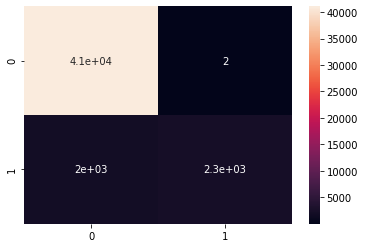

In [224]:
from sklearn.metrics import classification_report,confusion_matrix
ypred = model_rf.predict(X_test)
print(classification_report(y_test,ypred))
cm=confusion_matrix(y_test,ypred)
sns.heatmap(cm,annot=True)

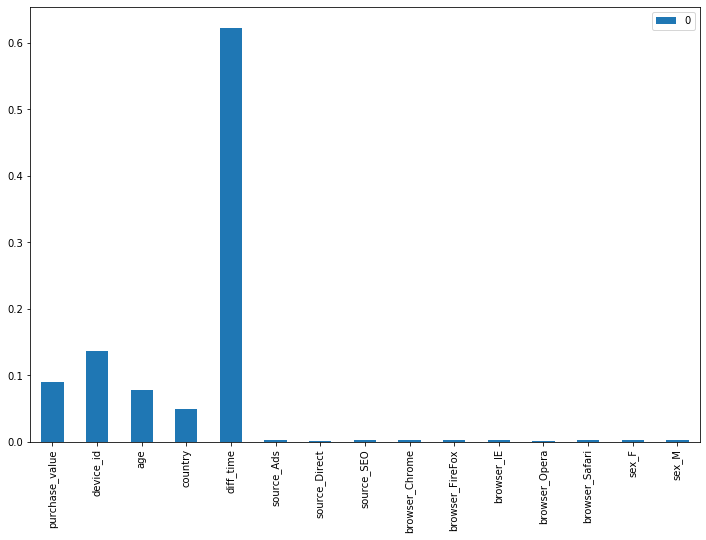

In [225]:
pd.DataFrame(model_rf.feature_importances_,index=X_train.columns).plot.bar(figsize=(12,8))

In [507]:
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import learning_curve
# N,train_score,val_score = learning_curve(model_rf,X_train,y_train,cv=5,scoring="recall",train_sizes=np.linspace(0.1,1,5))
# plt.figure(figsize=(12,8))
# plt.plot(N,train_score.mean(axis=1),label="train score")
# plt.plot(N,val_score.mean(axis=1),label="validation score")
# plt.legend()

In [227]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
parameters = {
        
       
    
        'min_samples_leaf': [4, 6,12]
        
    }
grid_rf = GridSearchCV(RandomForestClassifier(max_depth=5) , parameters, cv=5,scoring="recall") 

              precision    recall  f1-score   support

           0       0.95      1.00      0.98     41089
           1       1.00      0.53      0.70      4245

    accuracy                           0.96     45334
   macro avg       0.98      0.77      0.84     45334
weighted avg       0.96      0.96      0.95     45334



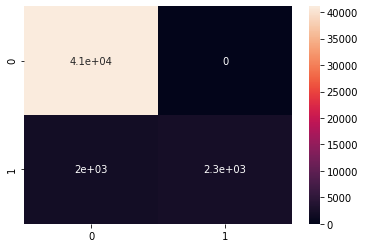

In [228]:
grid_rf.fit(X_train,y_train)
ypred = grid_rf.best_estimator_.predict(X_test)
print(classification_report(y_test,ypred))
cm=confusion_matrix(y_test,ypred)
sns.heatmap(cm,annot=True)

In [229]:
grid_rf.best_estimator_

RandomForestClassifier(max_depth=5, min_samples_leaf=4)

In [230]:
X_train=X_train.drop(["source_Ads","source_Direct","source_SEO","browser_Chrome","browser_FireFox","browser_IE","browser_Opera","browser_Safari","sex_F","sex_M"],axis=1)
X_test=X_test.drop(["source_Ads","source_Direct","source_SEO","browser_Chrome","browser_FireFox","browser_IE","browser_Opera","browser_Safari","sex_F","sex_M"],axis=1)


In [231]:
##test

In [232]:
class_weight = int(y_train.value_counts()[0]/y_train.value_counts()[1])
class_weight

9

In [233]:
int(y_test.value_counts()[0]/y_test.value_counts()[1])

9

In [234]:
model_rf3 = RandomForestClassifier(class_weight="balanced",max_depth=5, min_samples_leaf=4)

              precision    recall  f1-score   support

           0       0.95      1.00      0.98     41089
           1       1.00      0.53      0.70      4245

    accuracy                           0.96     45334
   macro avg       0.98      0.77      0.84     45334
weighted avg       0.96      0.96      0.95     45334

[[41086     3]
 [ 1982  2263]]


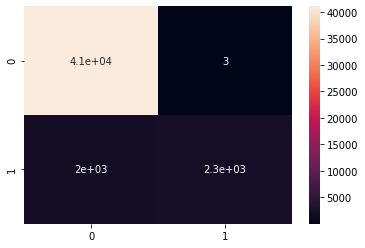

In [235]:
model_rf3.fit(X_train,y_train)
ypred = model_rf3.predict(X_test)
print(classification_report(y_test,ypred))
print(confusion_matrix(y_test,ypred))
cm=confusion_matrix(y_test,ypred)
sns.heatmap(cm,annot=True)

In [236]:
##test

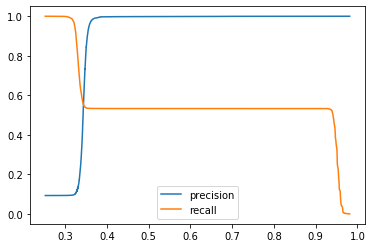

In [237]:
from sklearn.metrics import precision_recall_curve
precision,recall,thresold = precision_recall_curve(y_test,model_rf3.predict_proba(X_test)[:,1])
plt.plot(thresold,precision[:-1],label="precision")
plt.plot(thresold,recall[:-1],label="recall")
plt.legend()

In [238]:
thresold=0.348
ypred =  model_rf3.predict_proba(X_test)[:,1] >thresold

In [239]:
from sklearn.metrics import recall_score

In [240]:
print(classification_report(y_test,ypred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97     41089
           1       0.74      0.54      0.62      4245

    accuracy                           0.94     45334
   macro avg       0.85      0.76      0.80     45334
weighted avg       0.93      0.94      0.93     45334



[[40273   816]
 [ 1953  2292]]


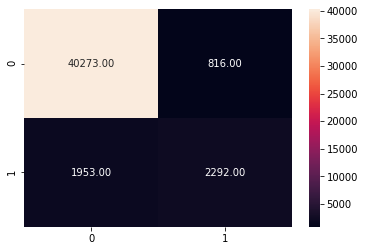

In [241]:
print(confusion_matrix(y_test,ypred))
cm=confusion_matrix(y_test,ypred)
sns.heatmap(cm,annot=True,fmt='.2f')

# Feature engineering

In [242]:
#  add new columns

In [243]:
devicecount = len(dataset) * [0]
devicecount = dataset.groupby('device_id')['user_id'].count()
devicecount = devicecount[dataset['device_id']]
devicecount = devicecount.reset_index().drop('device_id', axis = 1)
devicecount.columns = ['device_count']

In [244]:
dataset = pd.concat([dataset,devicecount], axis=1)

In [245]:
dataset['day_signup'] = pd.to_datetime(dataset['signup_time']).dt.dayofweek
dataset['day_purchase'] = pd.to_datetime(dataset['purchase_time']).dt.dayofweek
dataset['week_signup'] = pd.to_datetime(dataset['signup_time']).dt.weekofyear
dataset['week_purchase'] = pd.to_datetime(dataset['purchase_time']).dt.weekofyear
dataset['diff_day'] = (dataset['day_purchase']-dataset['day_signup']).abs()
dataset["diff_week"] =(dataset['week_purchase']-dataset['week_signup']).abs()

In [246]:
dataset.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,diff_time,device_count,day_signup,day_purchase,week_signup,week_purchase,diff_day,diff_week
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,4506682.0,1,1,5,9,16,4,7
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944.0,1,6,0,23,24,6,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1.0,12,3,3,1,1,0,0
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,0,492085.0,1,1,0,18,19,1,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,4361461.0,1,1,2,30,37,1,7


In [247]:
dataset.columns

Index(['user_id', 'signup_time', 'purchase_time', 'purchase_value',
       'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class',
       'country', 'diff_time', 'device_count', 'day_signup', 'day_purchase',
       'week_signup', 'week_purchase', 'diff_day', 'diff_week'],
      dtype='object')

In [248]:
dataset_fraud = dataset[dataset["class"] ==1]
dataset_no_fraud = dataset[dataset["class"] ==0]

0    0.605116
1    0.113844
2    0.095117
3    0.073140
4    0.056745
5    0.037807
6    0.018232
Name: diff_day, dtype: float64


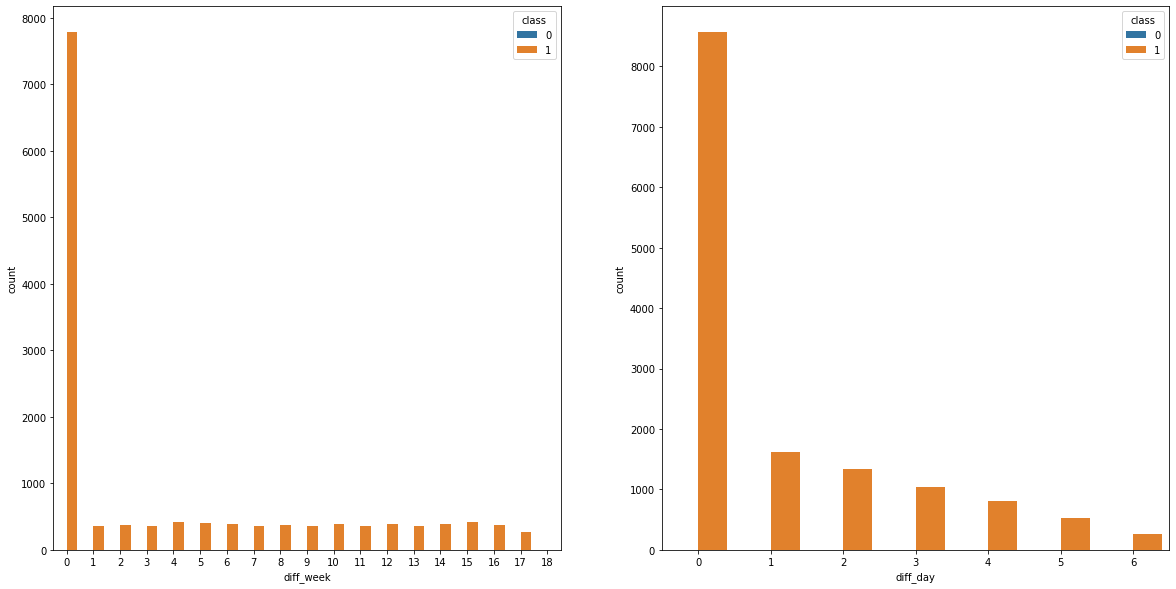

In [249]:
print(dataset_fraud.diff_day.value_counts(normalize=True))  ## 60% fraud same day
plt.figure(figsize=(20,10))
plt.subplot(121) 
sns.countplot(dataset_fraud.diff_week,hue=dataset["class"])
plt.subplot(122) 
sns.countplot(dataset_fraud.diff_day,hue=dataset["class"])
plt.show()

6    0.157021
4    0.154901
5    0.151862
3    0.149742
0    0.147622
2    0.120910
1    0.117942
Name: day_purchase, dtype: float64


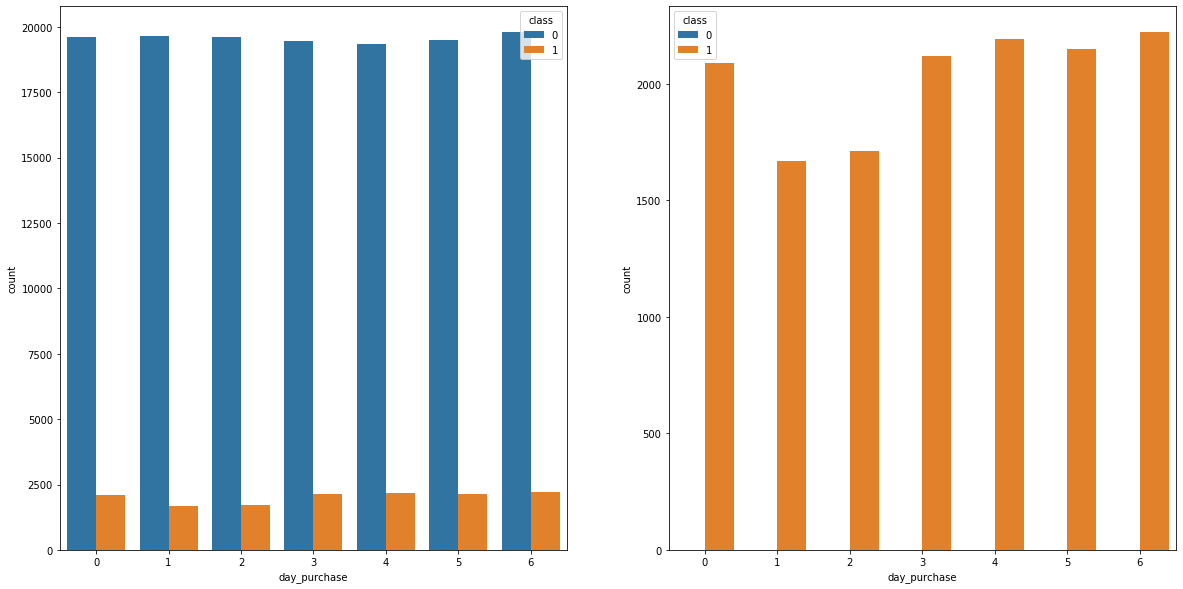

In [250]:
print(dataset_fraud.day_purchase.value_counts(normalize=True))  ## 60% fraud same day
plt.figure(figsize=(20,10))
plt.subplot(121) 
sns.countplot(dataset.day_purchase,hue=dataset["class"])
plt.subplot(122) 
sns.countplot(dataset_fraud.day_purchase,hue=dataset["class"])
plt.show()

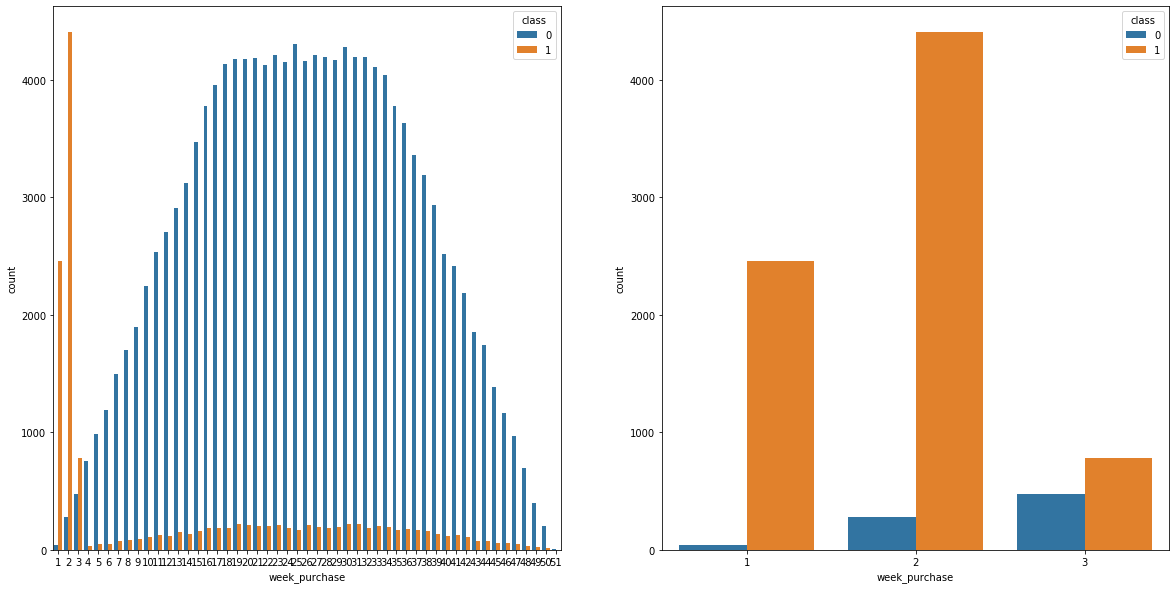

In [251]:

plt.figure(figsize=(20,10))
plt.subplot(121) 
sns.countplot(dataset.week_purchase,hue=dataset["class"])
plt.subplot(122) 
sns.countplot(dataset.week_purchase[dataset["week_purchase"]<4],hue=dataset["class"])
plt.show()

In [252]:
d_w_4_f = len(dataset[dataset["week_purchase"]<4])
d_w_4 = len(dataset_fraud[dataset["week_purchase"]<4])
rate_fraud_week_123 = d_w_4/d_w_4_f
print(rate_fraud_week_123)   #90% fraud in 1,2,3 week 

0.9057833609860156


In [253]:
dataset_fraud["week_purchase"].value_counts(normalize=True).head() #rate of fraud compared to total fraud (week)

2     0.311215
1     0.173839
3     0.055049
30    0.015688
19    0.015547
Name: week_purchase, dtype: float64

In [254]:
rate_fraud_w = dataset[dataset['class']==1].week_purchase.value_counts()/dataset.week_purchase.value_counts(sort=True) ##fraud rate related to  total number of transactions each week
rate_fraud_w.fillna(value=0,inplace=True)
rate_fraud_w.head()

1    0.982428
2    0.940825
3    0.621708
4    0.041667
5    0.050000
Name: week_purchase, dtype: float64

In [255]:
rate_fraud_w = pd.DataFrame(rate_fraud_w)

In [256]:
rate_fraud_w = rate_fraud_w.reset_index()

In [257]:
rate_fraud_w = rate_fraud_w.rename({"index":"week_purchase","week_purchase":"rate_fraud_w"},axis=1)

In [258]:
rate_fraud_w.head()

,week_purchase,rate_fraud_w
0,1,0.982428
1,2,0.940825
2,3,0.621708
3,4,0.041667
4,5,0.050000


In [260]:
dataset = dataset.merge(rate_fraud_w, left_on=["week_purchase"], right_on=["week_purchase"], how='left')

In [261]:
dataset.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,...,country,diff_time,device_count,day_signup,day_purchase,week_signup,week_purchase,diff_day,diff_week,rate_fraud_w
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,...,Japan,4506682.0,1,1,5,9,16,4,7,0.047222
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,...,United States,17944.0,1,6,0,23,24,6,1,0.042877
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,...,United States,1.0,12,3,3,1,1,0,0,0.982428
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,...,0,492085.0,1,1,0,18,19,1,1,0.050057
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,...,United States,4361461.0,1,1,2,30,37,1,7,0.047916


In [269]:
rate_f_country = dataset[dataset['class']==1].country.value_counts()/dataset.country.value_counts(sort=True) # #rate of fraud /country

In [270]:
rate_f_country = pd.DataFrame(rate_f_country).reset_index().fillna(value=0)

In [272]:
rate_f_country= rate_f_country.rename({"index":"country","country":"rate_f_country"},axis=1)

In [273]:
dataset = dataset.merge(rate_f_country, left_on=["country"], right_on=["country"], how='left')

In [274]:
dataset.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,...,diff_time,device_count,day_signup,day_purchase,week_signup,week_purchase,diff_day,diff_week,rate_fraud_w,rate_f_country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,...,4506682.0,1,1,5,9,16,4,7,0.047222,0.097865
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,...,17944.0,1,6,0,23,24,6,1,0.042877,0.095626
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,...,1.0,12,3,3,1,1,0,0,0.982428,0.095626
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,...,492085.0,1,1,0,18,19,1,1,0.050057,0.085723
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,...,4361461.0,1,1,2,30,37,1,7,0.047916,0.095626


In [483]:
dataset["diff_time"] = np.log(dataset["diff_time"])

In [484]:
X=dataset.drop(["class",'user_id','signup_time','purchase_time','ip_address',"device_id",'country'],axis=1)
y=dataset["class"]

In [485]:
X.head()

,purchase_value,source,browser,sex,age,diff_time,device_count,day_signup,day_purchase,week_signup,week_purchase,diff_day,diff_week,rate_fraud_w,rate_f_country
0,34,SEO,Chrome,M,39,15.321072,1,1,5,9,16,4,7,0.047222,0.097865
1,16,Ads,Chrome,F,53,9.795011,1,6,0,23,24,6,1,0.042877,0.095626
2,15,SEO,Opera,M,53,0.000000,12,3,3,1,1,0,0,0.982428,0.095626
3,44,SEO,Safari,M,41,13.106407,1,1,0,18,19,1,1,0.050057,0.085723
4,39,Ads,Safari,M,45,15.288318,1,1,2,30,37,1,7,0.047916,0.095626


In [488]:
X = pd.get_dummies(X)

In [489]:
X.head()

,purchase_value,age,diff_time,device_count,day_signup,day_purchase,week_signup,week_purchase,diff_day,diff_week,...,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_F,sex_M
0,34,39,15.321072,1,1,5,9,16,4,7,...,0,0,1,1,0,0,0,0,0,1
1,16,53,9.795011,1,6,0,23,24,6,1,...,1,0,0,1,0,0,0,0,1,0
2,15,53,0.000000,12,3,3,1,1,0,0,...,0,0,1,0,0,0,1,0,0,1
3,44,41,13.106407,1,1,0,18,19,1,1,...,0,0,1,0,0,0,0,1,0,1
4,39,45,15.288318,1,1,2,30,37,1,7,...,1,0,0,0,0,0,0,1,0,1


              precision    recall  f1-score   support

           0       0.95      1.00      0.98     41089
           1       0.98      0.53      0.69      4245

    accuracy                           0.96     45334
   macro avg       0.97      0.77      0.83     45334
weighted avg       0.96      0.96      0.95     45334



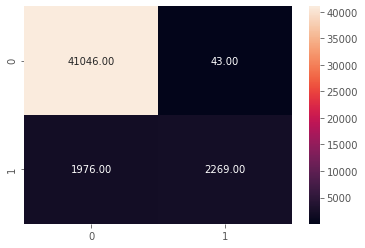

In [490]:
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42,stratify = y)
# scaler = StandardScaler()
# X_train_sc =scaler.fit_transform(X_train)
# X_test_sc = scaler.transform(X_test)
model_rf= RandomForestClassifier(class_weight="balanced")
model_rf.fit(X_train_sc,y_train)

ypred = model_rf.predict(X_test_sc)
print(classification_report(y_test,ypred))
cm=confusion_matrix(y_test,ypred)
sns.heatmap(cm,annot=True,fmt='.2f')

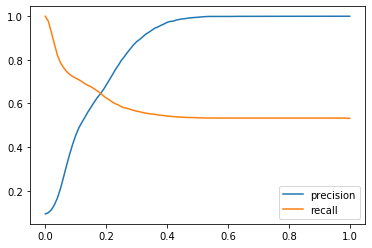

In [280]:
from sklearn.metrics import precision_recall_curve
precision,recall,thresold = precision_recall_curve(y_test,model_rf.predict_proba(X_test_sc)[:,1])
plt.plot(thresold,precision[:-1],label="precision")
plt.plot(thresold,recall[:-1],label="recall")
plt.legend()

              precision    recall  f1-score   support

           0       0.95      1.00      0.98     41089
           1       1.00      0.53      0.70      4245

    accuracy                           0.96     45334
   macro avg       0.98      0.77      0.84     45334
weighted avg       0.96      0.96      0.95     45334



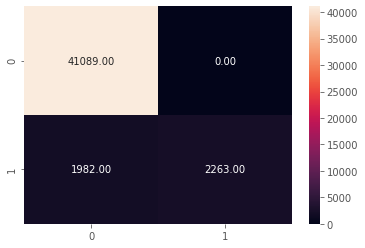

In [494]:
thresold=0.8
ypred =  model_rf.predict_proba(X_test_sc)[:,1] >thresold
print(classification_report(y_test,ypred))
cm=confusion_matrix(y_test,ypred)
sns.heatmap(cm,annot=True,fmt='.2f')

<Figure size 1440x720 with 0 Axes>

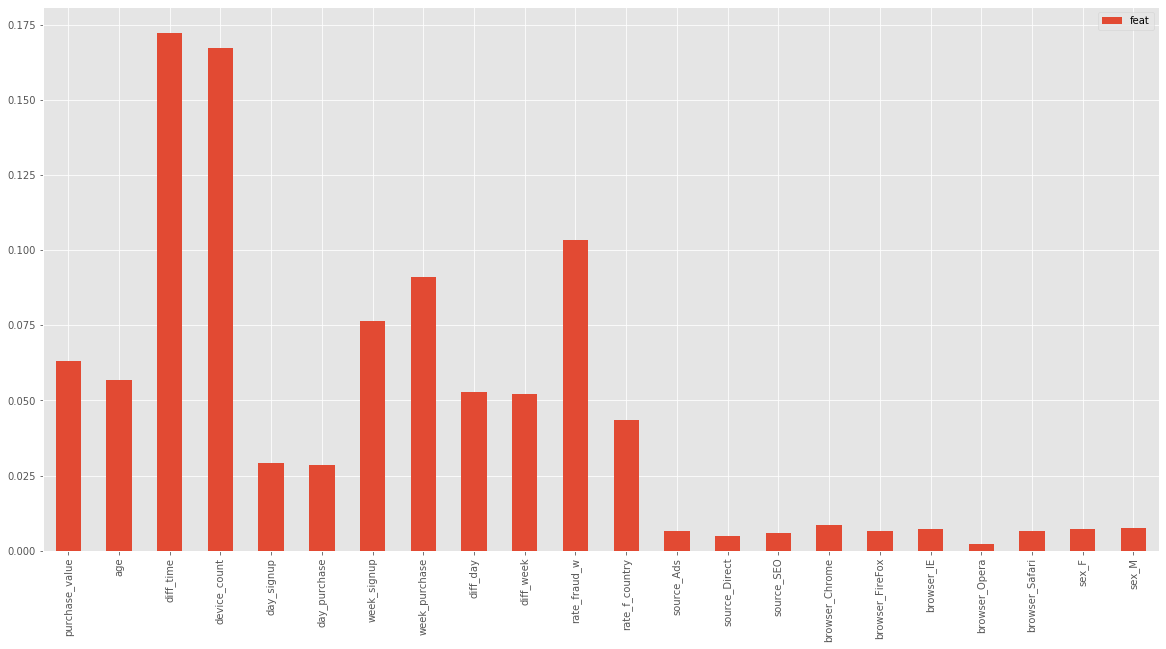

In [500]:

feat_import.plot.bar(figsize=(20,10))

In [501]:
feat_import[feat_import["feat"]>0.05]

,feat
purchase_value,0.063048
age,0.056928
diff_time,0.172337
device_count,0.167287
week_signup,0.076356
week_purchase,0.091254
diff_day,0.052762
diff_week,0.052235
rate_fraud_w,0.103442


In [341]:
X=dataset.drop(["class",'user_id','signup_time','purchase_time','ip_address',"device_id","country","age","sex","browser","source"],axis=1)
y=dataset["class"]

In [295]:
X.head()

,purchase_value,diff_time,device_count,day_signup,day_purchase,week_signup,week_purchase,diff_day,diff_week,rate_fraud_w,rate_f_country
0,34,4506682.0,1,1,5,9,16,4,7,0.047222,0.097865
1,16,17944.0,1,6,0,23,24,6,1,0.042877,0.095626
2,15,1.0,12,3,3,1,1,0,0,0.982428,0.095626
3,44,492085.0,1,1,0,18,19,1,1,0.050057,0.085723
4,39,4361461.0,1,1,2,30,37,1,7,0.047916,0.095626


              precision    recall  f1-score   support

           0       0.95      1.00      0.98     41089
           1       0.99      0.54      0.69      4245

    accuracy                           0.96     45334
   macro avg       0.97      0.77      0.84     45334
weighted avg       0.96      0.96      0.95     45334



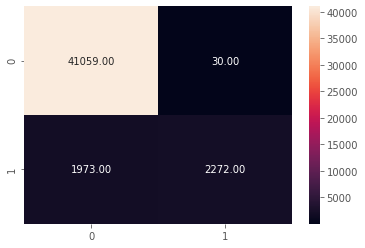

In [343]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42,stratify = y)
# scaler = StandardScaler()
# X_train_sc =scaler.fit_transform(X_train)
# X_test_sc = scaler.transform(X_test)
model_rf= RandomForestClassifier(class_weight="balanced")
model_rf.fit(X_train_sc,y_train)
ypred = model_rf.predict(X_test_sc)
print(classification_report(y_test,ypred))
cm=confusion_matrix(y_test,ypred)
sns.heatmap(cm,annot=True,fmt='.2f')

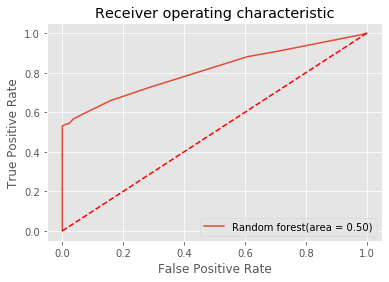

In [344]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, model_rf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, model_rf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random forest(area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [ ]:
### tester d'autres algo !!

In [ ]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import AdaBoostClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC

# XGBOOST

In [298]:
import xgboost as xgb

In [309]:
int(y_test.value_counts()[0]/y_test.value_counts()[1])

9

In [345]:
model_xgb = xgb.XGBClassifier(objective='binary:logistic',scale_pos_weight=9,learning_rate=0.02,n_estimators=500,max_depth = 1)

In [346]:
model_xgb.fit(X_train_sc,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.02, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=9, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

              precision    recall  f1-score   support

           0       0.95      1.00      0.98     41089
           1       0.99      0.54      0.69      4245

    accuracy                           0.96     45334
   macro avg       0.97      0.77      0.84     45334
weighted avg       0.96      0.96      0.95     45334



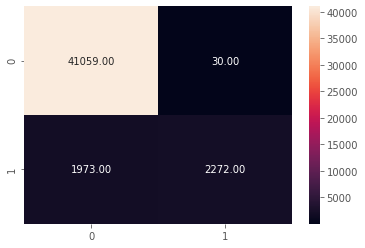

In [347]:
ypred = model_rf.predict(X_test_sc)
print(classification_report(y_test,ypred))
cm=confusion_matrix(y_test,ypred)
sns.heatmap(cm,annot=True,fmt='.2f')

In [348]:
cv_params = {'max_depth': [1,2,3,4,], 'min_child_weight': [1,2,3,4]}    # parameters to be tries in the grid search
fix_params = {'learning_rate': 0.02, 'n_estimators': 200, "scale_pos_weight":9}   #other parameters, fixed for the moment 
csv = GridSearchCV(xgb.XGBClassifier(**fix_params), cv_params, scoring = "recall", cv = 5)

In [349]:
csv.fit(X_train_sc,y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.02, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=200, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=9, subsample=None,
                                     tree_method=None, va

In [351]:
ypred = csv.best_estimator_.predict(X_test_sc)


              precision    recall  f1-score   support

           0       0.97      0.93      0.95     41089
           1       0.52      0.72      0.61      4245

    accuracy                           0.91     45334
   macro avg       0.75      0.83      0.78     45334
weighted avg       0.93      0.91      0.92     45334



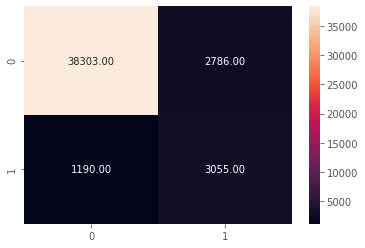

In [352]:

print(classification_report(y_test,ypred))
cm=confusion_matrix(y_test,ypred)
sns.heatmap(cm,annot=True,fmt='.2f')

In [357]:
X_train_sc.shape

(105778, 11)

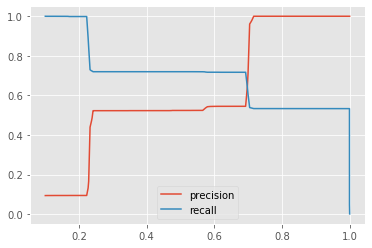

In [353]:
from sklearn.metrics import precision_recall_curve
precision,recall,thresold = precision_recall_curve(y_test,model_xgb.predict_proba(X_test_sc)[:,1])
plt.plot(thresold,precision[:-1],label="precision")
plt.plot(thresold,recall[:-1],label="recall")
plt.legend()

              precision    recall  f1-score   support

           0       0.95      1.00      0.98     41089
           1       0.96      0.54      0.69      4245

    accuracy                           0.95     45334
   macro avg       0.96      0.77      0.83     45334
weighted avg       0.95      0.95      0.95     45334



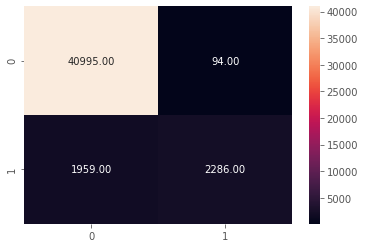

In [362]:
thresold=0.
ypred =  model_xgb.predict_proba(X_test_sc)[:,1] >thresold
print(classification_report(y_test,ypred))
cm=confusion_matrix(y_test,ypred)
sns.heatmap(cm,annot=True,fmt='.2f')

In [ ]:
ypred = grid_result.best_estimator_.predict(X_test_sc)

In [ ]:

print(classification_report(y_test,ypred))
cm=confusion_matrix(y_test,ypred)
sns.heatmap(cm,annot=True,fmt='.2f')

# SMOTE  / OVERSAMPLING

In [363]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto', random_state=42,k_neighbors=5)
X_train_smote, y_train_smote = smote.fit_sample(X_train_sc, y_train)

In [404]:
model_xgb_smote = xgb.XGBClassifier(objective='binary:logistic',learning_rate=0.1,n_estimators=300,max_depth = 2)

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     41089
           1       0.92      0.55      0.68      4245

    accuracy                           0.95     45334
   macro avg       0.94      0.77      0.83     45334
weighted avg       0.95      0.95      0.95     45334



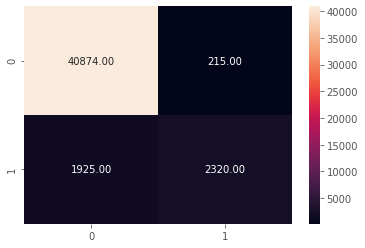

In [405]:
model_xgb_smote.fit(X_train_smote,y_train_smote)
ypred = model_xgb_smote.predict(X_test_sc)
print(classification_report(y_test,ypred))
cm=confusion_matrix(y_test,ypred)
sns.heatmap(cm,annot=True,fmt='.2f')

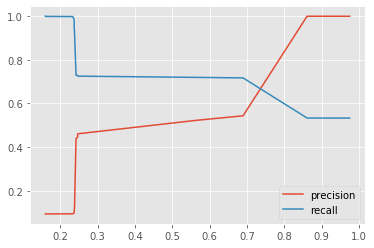

In [366]:
from sklearn.metrics import precision_recall_curve
precision,recall,thresold = precision_recall_curve(y_test,model_xgb_smote.predict_proba(X_test_sc)[:,1])
plt.plot(thresold,precision[:-1],label="precision")
plt.plot(thresold,recall[:-1],label="recall")
plt.legend()

              precision    recall  f1-score   support

           0       0.96      1.00      0.97     41089
           1       0.92      0.55      0.69      4245

    accuracy                           0.95     45334
   macro avg       0.94      0.77      0.83     45334
weighted avg       0.95      0.95      0.95     45334



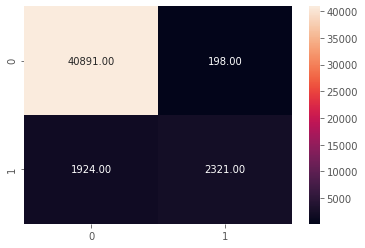

In [374]:
thresold=0.71
ypred =  model_xgb_smote.predict_proba(X_test_sc)[:,1] >thresold
print(classification_report(y_test,ypred))
cm=confusion_matrix(y_test,ypred)
sns.heatmap(cm,annot=True,fmt='.2f')

# la fin